In [12]:
import os
import cv2
import numpy as np

from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoard8by6

this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, f"image1.jpg")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoard8by6

camera_properties = {
    "width": 640,
    "height": 480,
    "K": [[295.79606866959824, 0.0, 321.2621599038631],
          [0.0, 299.5389048862878, 241.73616515312332],
          [0.0, 0.0, 1.0]],
    "D": [-0.23543978771661125,
          0.03637781479419574,
          -0.0033069818601306755,
          -0.0012140708179525926,
          0.0],
    "P": [[201.14027404785156, 0.0, 319.5586620845679, 0.0],
          [0.0, 239.74398803710938, 237.60151004037834, 0.0],
          [0.0, 0.0, 1.0, 0.0]]
}

homography = [ [ 0.45484525,  0.33783685,  0.11218921],
            [-0.02801287,  1.02463437, -0.07835274],
            [-0.19216963,  3.63163831,  1.        ]]


In [13]:
# Normalize homography matrix
from dt_computer_vision.camera.homography import Homography, pose_from_homography

H = Homography(homography)
H_copy = H.copy()
tvec, R = pose_from_homography(H)

print("In the camera reference system:")
print("R (after polar decomposition):\n", R, f"det(R) = {np.linalg.det(R)}")
print("tvec:\n", tvec)

In the camera reference system:
R (after polar decomposition):
 [[ 0.99752835  0.04838635 -0.05095039]
 [ 0.03620228  0.26754536  0.96286493]
 [ 0.06022106 -0.96232959  0.26513239]] det(R) = 0.9999999999999997
tvec:
 [-0.10768187  0.02474266  0.36206338]


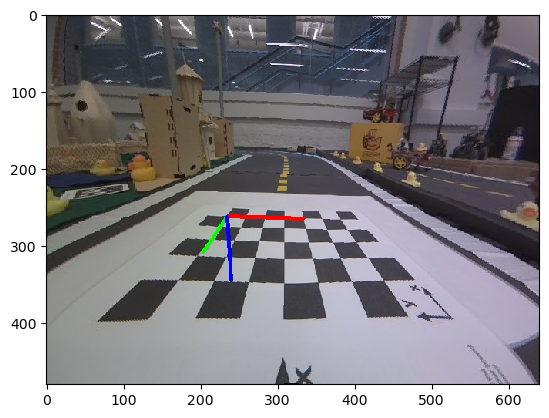

In [14]:
import cv2
from matplotlib import pyplot as plt
from dt_computer_vision.camera.types import CameraModel

# Convert rotation matrix to rotation vector
rvec, _ = cv2.Rodrigues(R)

# Draw frame axes
camera = CameraModel(**camera_properties)

image_rect = camera.rectifier.rectify(image)

cv2.drawFrameAxes(image_rect, camera.K, camera.D, rvec, tvec, 4 * board.square_size)

# Display the image
plt.imshow(cv2.cvtColor(image_rect, cv2.COLOR_BGR2RGB))

In [15]:
def compute_homography_from_poses(R1, tvec1, R2, tvec2, d_inv, normal):
    homography = np.dot(R2, R1.T) + d_inv * (np.dot(-R2, np.dot(R1.T, tvec1)) + tvec2) * normal.T
    return homography

R1 = R.copy()
tvec1 = tvec.copy().reshape(3, 1)

# Compute plane normal at camera pose 1
normal = np.array([[0], [0], [1]])
normal1 = np.dot(R1, normal)

# Compute plane distance to the camera frame 1
origin = np.zeros((3, 1))
origin1 = np.dot(R1, origin) + tvec1
d_inv1 = 1.0 / np.dot(normal1.T, origin1)

print(d_inv1)

[[7.98052754]]


Homography (Euclidean):
 [[ 1.5172165   1.08256011  0.37725796]
 [-0.146059    4.62225941 -0.35931526]
 [-0.19216963  3.63163831  1.        ]]
Homography:
 [[-7.59821443e-01 -2.88252357e+00  6.89562552e+02]
 [ 1.77081758e-01 -4.38593110e+00  9.25475059e+02]
 [ 3.77250131e-04 -7.04022265e-03  1.00000000e+00]]
Homography (DT):
 [[-7.59821443e-01 -2.88252357e+00  6.89562552e+02]
 [ 1.77081758e-01 -4.38593110e+00  9.25475059e+02]
 [ 3.77250131e-04 -7.04022265e-03  1.00000000e+00]]


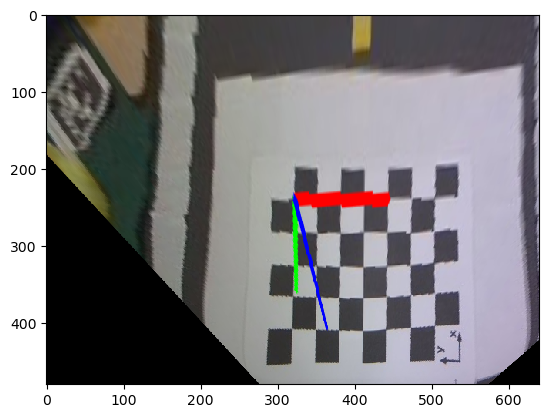

In [16]:
# Compute the homography in Euclidean space
R2 = np.eye(3)
tvec2 = np.array([0, 0.0, 0.3]).reshape(3, 1)

homography_euclidean = compute_homography_from_poses(R1, tvec1, R2, tvec2, d_inv1, normal1)

# Compute the full homography using the camera matrix
homography = np.dot(np.dot(camera.K, homography_euclidean), np.linalg.inv(camera.K))

# Normalize the homography matrices
homography /= homography[2, 2]
homography_euclidean /= homography_euclidean[2, 2]

print("Homography (Euclidean):\n", homography_euclidean)
print("Homography:\n", homography)

from dt_computer_vision.camera.homography import interpolate_homography
H_dt = interpolate_homography(H, tvec2, R2, camera)
print("Homography (DT):\n", H_dt)

# Use the computed homography to warp the image and display it side by side with the original image
warped = cv2.warpPerspective(image_rect, homography, (image.shape[1], image.shape[0]))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))

assert np.allclose(homography, H_dt)